In [1]:
import math
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['image.cmap'] = 'gray'

### import functions from scripts

In [2]:
import os
os.chdir('../saliency_model/')

In [3]:
from utils import *
from itti_koch_features import *

In [4]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.transform import resize
from scipy import ndimage as nd

## Load the images

In [5]:
img = mpimg.imread('../imgs/balloons.png')
# img = mpimg.imread('../imgs/SpongeBob.png')

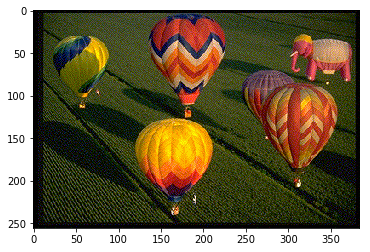

In [6]:
plt.imshow(img);

convert to double if image is uint8

In [7]:
# TODO 

---

## Determine the size and the number of center scales:  
First we scale the image to different sizes, so it has different resolutions we can work with.

In [8]:
mapwidth = 64
mapheight = round(img.shape[0] * (mapwidth / img.shape[1]))
scalars = [1, 2, 3]

img_scales = downsample_image(img, mapheight, mapwidth, scalars)

In [9]:
mapsize = [ round(np.size(img,0) / np.size(img,1) * mapwidth), mapwidth ];
mapsize
# chanmap = chanmap + wj * imresize(maps{ci}{cj}, mapSize ); #TODO: weighted scale

[43, 64]

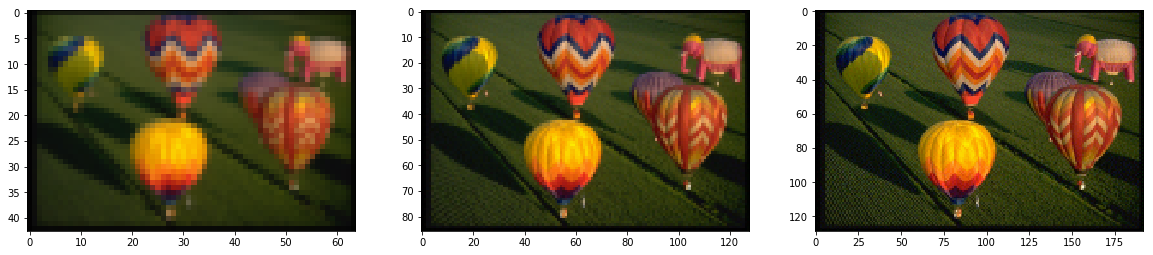

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_scales[0])
ax[1].imshow(img_scales[1])
ax[2].imshow(img_scales[2]);

---

## CHANNELS

## Orientation filter

In [11]:
### Calculate Means (intensity)

In [12]:
intensities = compute_intensity(img_scales)

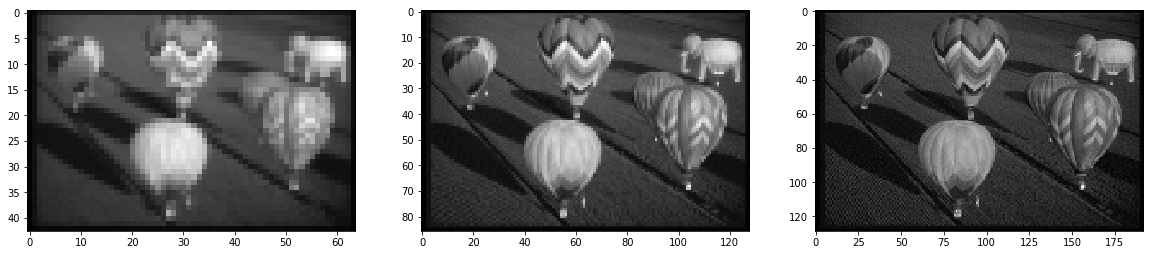

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(intensities[0])
ax[1].imshow(intensities[1])
ax[2].imshow(intensities[2]);

### Generate multiple Gabor filters

In [14]:
kernels = []

phase = [0, 90]  # should be used in offset
sigma = 4
frequency = 0.1

theta = 4 # decides how many different angles of the filter we will have 


# for ph in phase:
for theta in range(int(theta)):
    theta = theta / 4. * np.pi
    kernel = np.real(gabor_kernel(frequency, theta=theta,
                                  sigma_x=sigma, sigma_y=sigma,
                                  offset=0))
    kernels.append(kernel)

### Vizualize all the filters

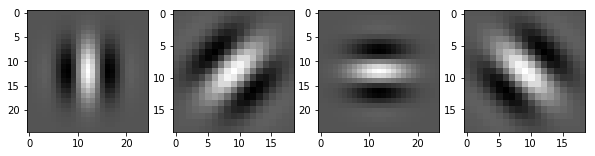

In [15]:
j = len(kernels)

fig, ax = plt.subplots(1, j, figsize=(10, 10))
for i in range(j):
    ax[i].imshow(kernels[i])

In [16]:
def compute_feats(image, kernels):
    '''compute features for multiple kernels: convolve with image'''
#     feats = np.zeros_like(image)
    feats = []
    
    for kernel in kernels:
        filtered = nd.convolve(image, kernel)
        feats.append(filtered)
        
#         feats = feats + filtered
#     feats = feats / len(kernels)  # normalize
    
    return feats 

In [17]:
img_orient = []

for i in range(len(intensities)):
    compute_feats(intensities[i], kernels)
    
    img_orient.append(compute_feats(intensities[i], kernels))

## SALIENCY
### (1) apply center-surround to feature map

Convolve the feature maps with the center surround function / Mexican Hat to get the saliency maps.

In [18]:
orientations = img_orient[0]

In [19]:
img = orientations[1]

rf1 = receptive_field_matrix(lambda x, y: gaussian2D(x, y, .1))
rf = receptive_field_matrix(lambda x, y: gaussian2D(x, y, 3))

img = signal.convolve2d(img, rf1, mode='same')
convolved = signal.convolve2d(img, rf, mode='same')
# convolved = signal.convolve(rf, img, mode='valid')

res = (img - convolved)**2
res2 = abs(img-convolved)

In [20]:
def convolve_receptive_field(input_list, sigma1, sigma2):
    """
    convolves all images of the input list with the sigma-combinations;
    returns a nested list of convolved images, where the first index is associated with the image,
    and the second index is associated with the sigmas (kernel-size)
    """
    if (len(sigma1) != len(sigma2)):
        # TODO make this a useful error message...
        print("Amount of sigmas for inner and outer Gaussian have to be the same!")
        return
        
    # outer loop over the images
    output_list = []
    for img in input_list:
        
        # inner loop over the sigma-combinations
        img_hat = []
        for s1, s2 in zip(sigma1, sigma2):
#             print(s1, s2)
            # create receptive field and convolve with image
            rf1 = receptive_field_matrix(lambda x, y: gaussian2D(x, y, s1))
            rf = receptive_field_matrix(lambda x, y: gaussian2D(x, y, s2))

            # list containing different kernel sizes
            img_conv = signal.convolve2d(img, rf1, mode='same')  # convolve image with narrow gaussian
            convolved = signal.convolve2d(img, rf, mode='same') # convolve image with wide gaussian
            
            # substract one conv. img with the other
            conv = (img_conv - convolved)**2
            
#             img_hat.append(conv)                     # save as 2D list
#             output_list.append(img_hat)

            output_list.append(conv) # save as 1D list
            
        # list containing convolved versions of all images
        
    return output_list

In [21]:
sigma1 = [1, 1]
sigma2 = [3, 4]

convolution_maps = convolve_receptive_field(img_orient[0], sigma1, sigma2)
convolution_maps1 = convolve_receptive_field(img_orient[1], sigma1, sigma2)
convolution_maps2 = convolve_receptive_field(img_orient[2], sigma1, sigma2)

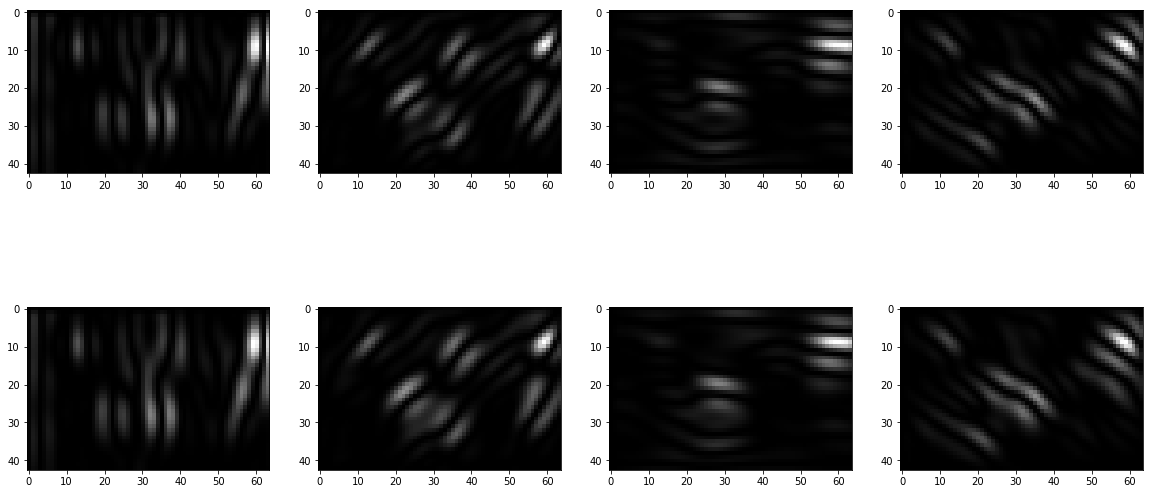

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0,0].imshow(convolution_maps[0])
ax[1,0].imshow(convolution_maps[1])
#ax[2,0].imshow(convolved[0][2])
ax[0,1].imshow(convolution_maps[2])
ax[1,1].imshow(convolution_maps[3])
#ax[2,1].imshow(convolved[1][2])
ax[0,2].imshow(convolution_maps[4])
ax[1,2].imshow(convolution_maps[5]);
#ax[2,2].imshow(convolved[2][2])
ax[0,3].imshow(convolution_maps[6])
ax[1,3].imshow(convolution_maps[7]);


## *QUESTION*:
What is done in the original MATLAB code is the following:   
(1) create 1-dim Gausskernel and convolve it with the image twice (in two dimensions) - I think this should be the same as what we directly do in two dimensions? They also only use a Gaussian kernel and not a real receptive field...  
(2) after convolution, get the saliency map by subtracting the convoluted image from the original intensities and squaring the difference (see what happens when flagging matlab_code to True)

**Why would we have to do this?**

## (2) judge the peakiness of a saliency map

## Normalize to 0 - 1 range

In [23]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [24]:
def normalize(X):
    return (X - X.min()) / (X.max() - X.min())

In [25]:
convolution_maps[0].max()

0.000990087054737031

In [26]:
for i,m in enumerate(convolution_maps):
    convolution_maps[i] = normalize(m)    

In [27]:
for i,m in enumerate(convolution_maps1):
    convolution_maps1[i] = normalize(m)    

In [28]:
for i,m in enumerate(convolution_maps2):
    convolution_maps2[i] = normalize(m)    

In [29]:
convolution_maps[0].max()

1.0

## Get weights for peakines

In [30]:
def get_local_maxima(sal_map, min_distance=1, threshold_abs=0.1):
    '''
    Input image, find local minima with min_distance window between points. 
    Return average of local minimas and their number
    '''
    
    coordinates = peak_local_max(sal_map, min_distance=min_distance, threshold_abs=threshold_abs)
    
    peak_avg = 0
    peak_num = np.shape(coordinates)[0]
        
    for x,y in coordinates:
        peak_avg = peak_avg + sal_map[x][y]
    
    peak_avg = peak_avg/peak_num
    
    return peak_avg, peak_num

In [31]:
def get_weight_map(peak_avg, peak_num):
    '''
    based on number of peaks and their average return weight of the map used for normalization
    measure of pickiness
    '''
    
    if peak_num <= 1:
        return 1
    else:
        return (1 - peak_avg)**2
            

In [32]:
weights = []

for i,m in enumerate(convolution_maps):
    peak_avg, peak_num = get_local_maxima(m, min_distance=1)
    weights.append(get_weight_map(peak_avg, peak_num))
    
weights

[0.5537057782601775,
 0.48866671702861236,
 0.4517932273528132,
 0.33985034383722756,
 0.3357645563576676,
 0.42696405838203577,
 0.44845448838549345,
 0.36572674211990647]

In [33]:
weights1 = []

for i,m in enumerate(convolution_maps1):
    peak_avg, peak_num = get_local_maxima(m, min_distance=1)
    weights1.append(get_weight_map(peak_avg, peak_num))

In [34]:
weights2 = []

for i,m in enumerate(convolution_maps1):
    peak_avg, peak_num = get_local_maxima(m, min_distance=1)
    weights2.append(get_weight_map(peak_avg, peak_num))

In [35]:
for i, m in enumerate(convolution_maps):
    convolution_maps[i] = weights[i] * m

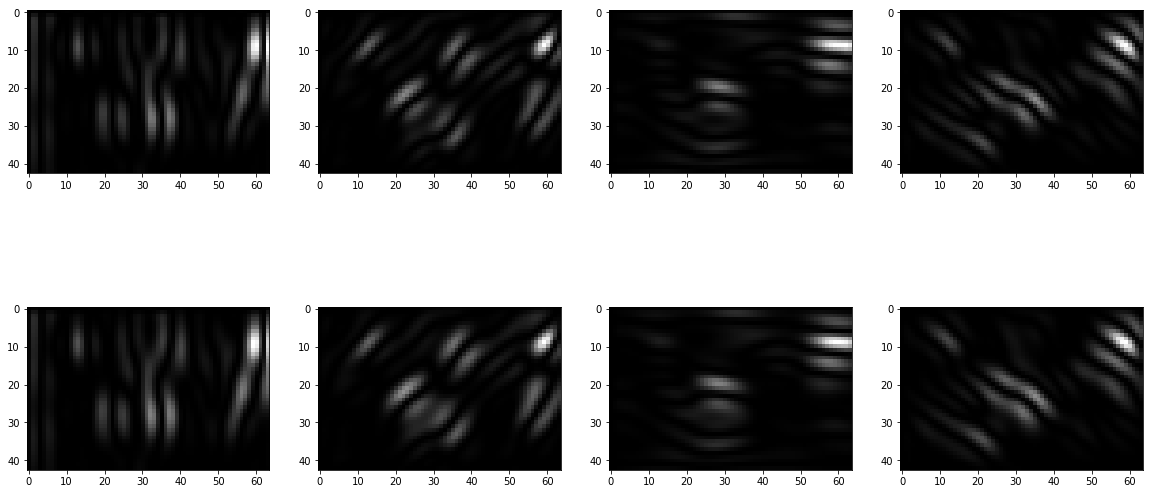

In [36]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0,0].imshow(convolution_maps[0])
ax[1,0].imshow(convolution_maps[1])
ax[0,1].imshow(convolution_maps[2])
ax[1,1].imshow(convolution_maps[3])
ax[0,2].imshow(convolution_maps[4])
ax[1,2].imshow(convolution_maps[5])
ax[0,3].imshow(convolution_maps[6]);
ax[1,3].imshow(convolution_maps[7]);

## Sum the maps 

In [37]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.transform import resize
from scipy import ndimage as nd

In [38]:
conv_maps_resize = []
orientation = np.zeros(mapsize)

for ii in convolution_maps:
    temp = resize(ii, mapsize, mode='constant', anti_aliasing=True)
    conv_maps_resize.append(temp)
    orientation = orientation + temp

In [39]:
conv_maps_resize1 = []
orientation1 = np.zeros(mapsize)

for i, m in enumerate(convolution_maps1):
    m = weights1[i] * m
    temp = resize(m, mapsize, mode='constant', anti_aliasing=True)
    conv_maps_resize1.append(temp)
    orientation1 = orientation1 + temp

In [40]:
conv_maps_resize2 = []
orientation2 = np.zeros(mapsize)

for i, m in enumerate(convolution_maps2):
    m = weights2[i] * m
    temp = resize(m, mapsize, mode='constant', anti_aliasing=True)
    conv_maps_resize2.append(temp)
    orientation2 = orientation2 + temp

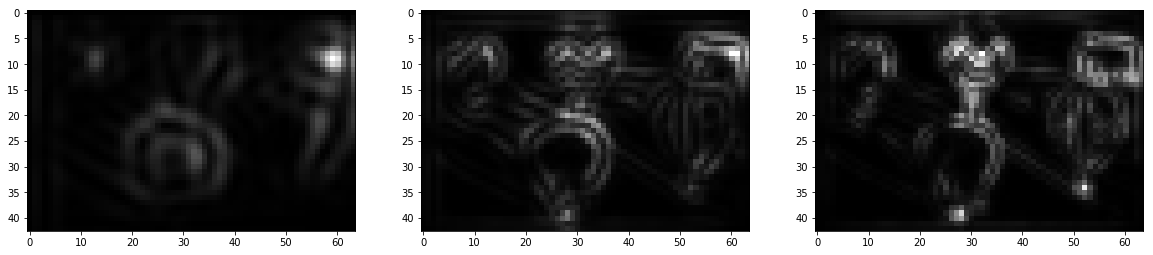

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(orientation)
ax[1].imshow(orientation1)
ax[2].imshow(orientation2);

In [42]:
map_orient =[orientation, orientation1, orientation2]

In [43]:
maps_orient_resize = []
orient_final = np.zeros(mapsize)

for m in map_orient:
    temp = resize(m, mapsize, mode='constant', anti_aliasing=True)
    maps_orient_resize.append(temp)
    orient_final = orient_final + temp

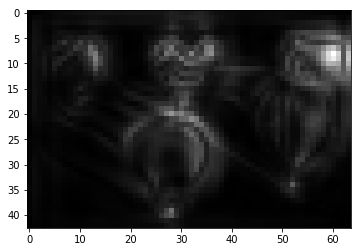

In [44]:
plt.imshow(orient_final);